In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder
from torch import nn
%matplotlib inline

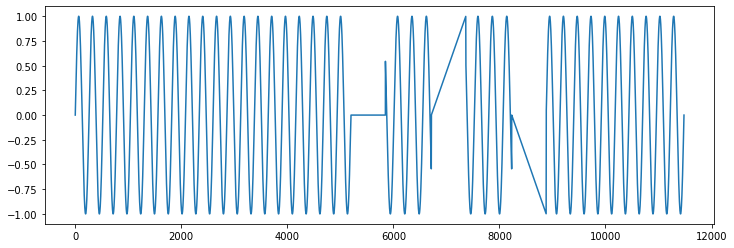

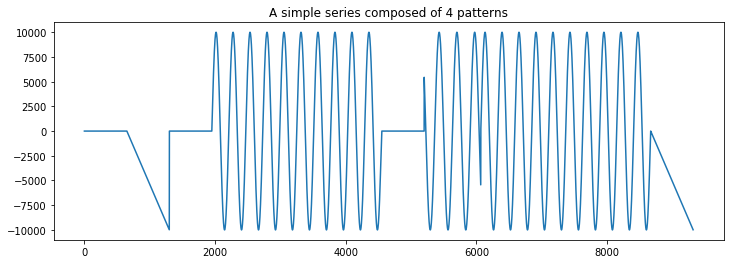

In [53]:
##### series 0 - half sine, half linear
nb_periods=10
nb_points=2600
x = np.linspace(-nb_periods*np.pi, nb_periods*np.pi, nb_points)
x2 = np.linspace(int(-nb_periods*np.pi/3), int(nb_periods*np.pi/3), int(nb_points/3))
aa=list(np.sin(x))
bb=list(np.zeros(int(nb_points/4)))
cc=list(np.sin(x2))
dd=list(np.arange(int(nb_points/4))/int(nb_points/-4))
ee=list(np.arange(int(nb_points/4))/int(nb_points/4))
y=list(np.arange(len(aa+aa+bb+cc+dd+aa)))
# On joint nos 3 patterns
serie_simple=np.array(aa+aa+bb+cc+ee+cc+dd+aa)

x = np.linspace(-nb_periods*np.pi, nb_periods*np.pi, nb_points)
x2 = np.linspace(int(-nb_periods*np.pi/3), int(nb_periods*np.pi/3), int(nb_points/3))
aa=list(np.sin(x))
bb=list(np.zeros(int(nb_points/4)))
cc=list(np.sin(x2))
dd=list(np.arange(int(nb_points/4))/int(nb_points/-4))
ee=list(np.arange(int(nb_points/4))/int(nb_points/4))
y=list(np.arange(len(aa+aa+bb+cc+dd+aa)))
# On joint nos 3 patterns
serie_simple=np.array(aa+aa+bb+cc+ee+cc+dd+aa)

serie_simple2=np.array(bb+dd+bb+aa+bb+cc+aa+dd)

# Visualisation 
fig=plt.figure(figsize=(12,4))
plt.plot(serie_simple)


plt.figure(figsize=(12,4))
plt.plot(serie_simple2*10000)
plt.title("A simple series composed of 4 patterns")
plt.show()

In [61]:
# get training data
df_train = serie_simple[:6500].reshape(-1,1)
df_test = serie_simple[6500:10000].reshape(-1,1)

df_train2 = serie_simple2[:6500].reshape(-1,1)
df_test2 = serie_simple2[6500:10000].reshape(-1,1)

In [62]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1


# data_dict = {"dim": 1, "uni_data_1": {"train": df_train, "test": df_test},
#              "uni_data_2": {"train": df_train2, "test": df_test2}}
data_dict = {"dim": 1, "uni_data_1": {"train": df_train, "test": df_test}}

In [83]:
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
data_dict = pp.normalize(data_dict,method="standard")
# data_dict = pp.discretize(data_dict,n_bins=100)
vocab_size = pp.build_vocab(data_dict)

window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]

# logging.info("Proceeding using {}...".format(params["device"]))
# logging.info(print_to_json(params))

2020-11-26 20:17:54,138 P34395 INFO Saving preprocessor into ./checkpoints/20201126-200611/preprocessor.pkl
2020-11-26 20:17:54,141 P34395 INFO Normalizing data
2020-11-26 20:17:54,145 P34395 INFO # of Discretized tokens: 2.4884695732825133
2020-11-26 20:17:54,146 P34395 INFO Generating sliding windows (size 16) for dataset [uni_data_1]
2020-11-26 20:17:54,184 P34395 INFO Saving hdf5 to ./datasets/anomaly/SMAP-MSL/hdf5/window_dict_ws=16_nrows=None.hdf5


In [84]:
encoder = MultiLSTMEncoder(vocab_size=None, embedding_dim=None, **params)

2020-11-26 20:17:54,576 P34395 INFO Compiling finished.


In [85]:
# batch_window = next(iter(train_iterator.loader))
# print(batch_window.shape)
# batch_window = batch_window.permute(0, 2, 1)  # b x win x ts_dim
# batch_window, y = batch_window[:, 0:-1, :], batch_window[:, -1, :]

In [92]:
# training
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

2020-11-26 20:18:25,041 P34395 INFO Start training for 2000 steps.
2020-11-26 20:18:25,042 P34395 INFO Epoch: 1
2020-11-26 20:18:28,589 P34395 INFO Epoch: 1, loss: 0.018
2020-11-26 20:18:28,593 P34395 INFO Saving model to ./checkpoints/20201126-200611/MultiLSTM_20201126-200611.pth
2020-11-26 20:18:28,596 P34395 INFO Epoch: 2
2020-11-26 20:18:33,145 P34395 INFO Epoch: 2, loss: 0.001
2020-11-26 20:18:33,149 P34395 INFO Saving model to ./checkpoints/20201126-200611/MultiLSTM_20201126-200611.pth
2020-11-26 20:18:33,152 P34395 INFO Epoch: 3


KeyboardInterrupt: 

In [93]:
encoder.load_encoder()

2020-11-26 20:18:37,945 P34395 INFO Loading model from ./checkpoints/20201126-200611/MultiLSTM_20201126-200611.pth


In [94]:
# def reconstruction_loader(loader, encoder):
train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
                                            batch_size=params["batch_size"], shuffle=False)
loader = train_iterator_non_shuffle.loader
encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["anomaly_label"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).cpu().numpy()
real_list = torch.cat(real_list).cpu().numpy()


0.0008198643711283712


In [95]:
recst = recst_list.reshape(-1)
real = real_list.reshape(-1)
print(recst.shape, real.shape)
# real = real_list[:,0,-1]
diff = np.sqrt((real-recst)**2)

(6485,) (6485,)


In [96]:
print(recst[0:10])
print(real[0:10])

[0.53186107 0.5662345  0.6001406  0.63304174 0.66522235 0.69732726
 0.728703   0.7607749  0.7941421  0.82835555]
[0.5325194  0.56239283 0.59226626 0.6520132  0.6818866  0.71176004
 0.7416335  0.77150697 0.8013804  0.8312538 ]


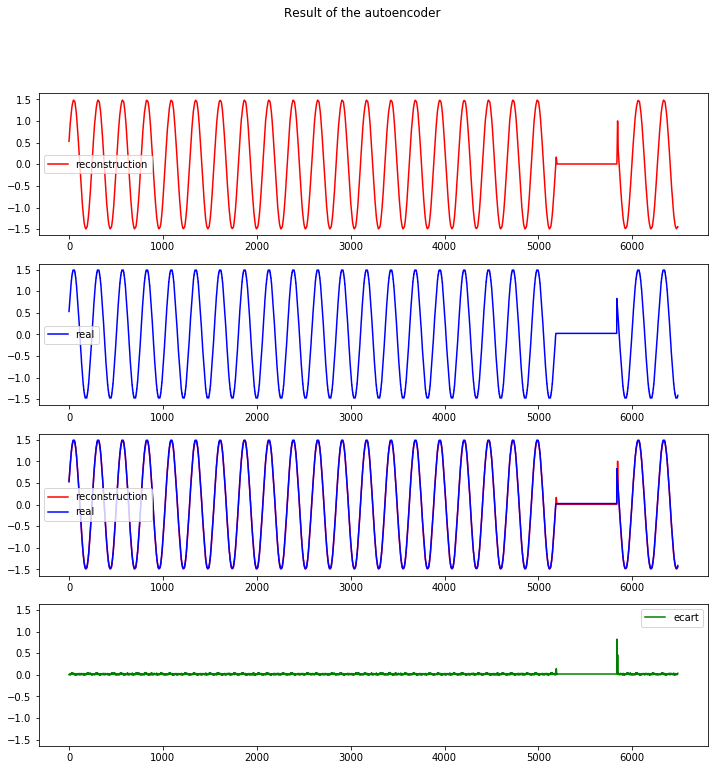

In [97]:
fig, ax = plt.subplots(nrows=4, sharey=True, figsize=(12,12))
ax[0].plot(recst, 'r', label='reconstruction')
ax[0].legend(loc='best')
ax[1].plot(real, 'b', label='real')
ax[1].legend(loc='best')

ax[2].plot(recst, 'r', label='reconstruction')
ax[2].plot(real, 'b', label='real')
ax[2].legend(loc='best')

ax[3].plot(diff, 'g', label='ecart')
ax[3].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()